# Final Project
CS696 Big Data

Professor Whitney

Team:

Kristi Werry - 823386935

William Ritchie - 815829203

## Description

## Imports

In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import to_timestamp, max, length
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import lit, avg, format_number
import sys
from pyspark.sql import SparkSession

## Functions

In [2]:
def Load_Datasets(sqlContext, files, schema):
    data = sqlContext.createDataFrame([], schema=schema)
    for file in files:
        temp_data = sqlContext.read.csv(path=file[0], schema=schema, dateFormat="yy.dd.MM", timestampFormat="yyyy-MM-dd")
        temp_data = temp_data.withColumn("country", lit(file[1]))
        data = data.union(temp_data)
    return data

## Importing Datasets

In [3]:
sqlContext = SparkSession.builder.appName("FinalProjectYoutube").getOrCreate();
root_dir = "youtube-new/";

# Set up the schema for reading in the data sets into a dataframe
customSchema = StructType([
  StructField("video_id", StringType(), True),
  StructField("trending_date", DateType(), True),
  StructField("title", StringType(), True),
  StructField("channel_title", StringType(), True),
  StructField("category_id", StringType(), True),
  StructField("publish_time", TimestampType(), True),
  StructField("tags", StringType(), True),
  StructField("views", IntegerType(), True),
  StructField("likes", IntegerType(), True),
  StructField("dislikes", IntegerType(), True),
  StructField("comment_count", IntegerType(), True),
  StructField("thumbnail_link", StringType(), True),
  StructField("comments_disabled", BooleanType(), True),
  StructField("ratings_disabled", BooleanType(), True),
  StructField("video_error_or_removed", BooleanType(), True),
  StructField("description", StringType(), True),
  StructField("country", StringType(), True)
])

# Associate csv files with respective countries
data_files = [
   (root_dir + "CAvideos.csv", "Canada"),
   (root_dir + "DEvideos.csv", "Germany"),
   (root_dir + "FRvideos.csv", "France"),
   (root_dir + "GBvideos.csv", "England"),
   (root_dir + "INvideos.csv", "India"),
   (root_dir + "JPvideos.csv", "Japan"),
   (root_dir + "KRvideos.csv", "South Korea"),
   (root_dir + "MXvideos.csv", "Mexixo"),
   (root_dir + "RUvideos.csv", "Russia"),
   (root_dir + "USvideos.csv", "US"),
]

# Read in datasets
youtube_data_df = Load_Datasets(sqlContext, data_files, customSchema)

## Dataset Cleaning 

#### Handle Duplicates

In [5]:
# When dropping the duplicate rows based on video_id we found that half of the dataset gets dropped.  So we now look at the 
# duplicate rows to find out more information about what is going on.  Looking at the duplicate rows you can see that the 
# same video can be trending for mulitple days and in different countries causing the same video to exist in multiple rows.
# We decided the "duplicates" were not actually truely duplicate rows, the information provided by these multiple entries 
# is still useful.  We determined a truely duplicate row requires the same: "video_id", "views", "likes", "dislikes",
# "country", and "trending_date" column values.
pandasdf = pd.DataFrame(data=youtube_data_df.take(100000), columns=youtube_data_df.columns)

pandas_df = pandasdf.loc[pandasdf['video_id'].duplicated()]

# We realized that a number of the duplicates have a "\n" for the video id, we decided to filter those rows out since
# they contain no useful information.  We remove these rows later on when dropping NA values from the dataset.
pandas_df = pandas_df[pandas_df['video_id'] != "\\n"]

# The video id value was manually selected by viewing the resulting dataframe from the previous line. You can see
# that this video was trending for multiple days and in mulitple countries, hence why it has mulitple rows in the 
# the dataset.
pandasdf[pandasdf['video_id'] == "n1WpP7iowLc"]

In [6]:
# The previous section determined that video_id was not sufficient in determining a truly duplicate row.  The following
# are a combination of the columns we think determine a truly duplicate row.  Meaning, if two rows have the same value
# in all of the below columns, then those two rows are indeed duplicates.
compare_duplicate_cols = ["video_id", "views", "likes", "dislikes", "country", "trending_date"]
row_count_with_dup = youtube_data_df.count()

# Drop duplicate rows
youtube_data_df = youtube_data_df.dropDuplicates(compare_duplicate_cols)

# View duplicate row count information
num_duplicates = row_count_with_dup - youtube_data_df.count()
print("Number of duplicates: " + str(num_duplicates))
print("Remaining number of rows: " + str(youtube_data_df.count()))

#### Handle NA's and Nulls

In [7]:
# The following are a list of the columns that we determined should not contain a null or NA value.  We could have
# done this when specifying the schema when we were importing the data, but we felt it necessary to learn more information
# about columns that contain nulls and NAs.  After playing around with the data we found that many of the values in the
# description column were NA.  We decided that this was okay because some videos might not have a description, thus
# this is why description is not included in the below list
no_nan_cols = ["video_id", "trending_date", "title", 
        "channel_title", "category_id",  
        "tags", "views", "likes", "dislikes", "comment_count", 
        "thumbnail_link", "comments_disabled", "ratings_disabled", 
        "video_error_or_removed", "country"]

row_count_with_nans = youtube_data_df.count()

# Drop nans from these columns
youtube_data_df = youtube_data_df.na.drop(subset=no_nan_cols) 

# View duplicate row count information
num_nans = row_count_with_nans - youtube_data_df.count()
print("Number of null,nans, and na's: " + str(num_nans))
print("Remaining number of rows: " + str(youtube_data_df.count()))

In [8]:
# We decided that it was advantageous to replace all of the nulls in the description column with empty strings, this
# way we do not need to check for nulls later on when working with this column in the dataset
youtube_data_df = youtube_data_df.fillna("", subset="description")

# Check that the description column contains no nulls
youtube_data_df.where(youtube_data_df.description.isNull()).count()

0

## Dropping duplicates but keeping max views

In [8]:
#Drop duplicate rows with the same video id and country, and keep the ones with the largest view count
nodup_data = all_data.orderBy(col("views").desc()).dropDuplicates(["video_id", "country"])

### Video Averages 

In [9]:
# takes in a dataframe, a grouping, and a column name and returns 
# the average of that column based on the group
def average_by_group(df, group, column):
    return df.groupBy(group).agg(avg(col(column)).alias("average"))

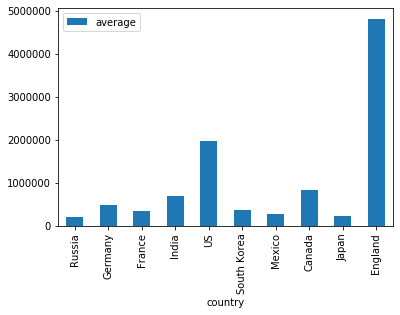

In [10]:
#Out of the trending videos, average number of views
#change to not duplicate data instead of all_data
average_by_group(nodup_data, "country", "views").toPandas().plot(kind='bar', y='average', x='country')

In [ ]:
average_by_group(nodup_data, "country", "likes").toPandas().plot(kind='bar', y='average', x='country')

In [ ]:
average_by_group(nodup_data, "country", "dislikes").toPandas().plot(kind='bar', y='average', x='country')

In [ ]:
average_by_group(nodup_data, "country", "comment_count").toPandas().plot(kind='bar', y='average', x='country')

In [ ]:
#testing removing duplicates
data = [
    ('a', 5, 'e'),
    ('a', 8, 'd'),
    ('a', 7, 'e'),
    ('b', 1, 'f'),
    ('b', 3, 'g')
]
df = sqlContext.createDataFrame(data, ["A", "B", "C"])
df.show()

In [ ]:
df.orderBy(col("B").desc()).dropDuplicates(["A"]).show()

In [ ]:
df.groupBy(['A', 'C']).agg(max('B')).show()

## Finding correlation
something wrong with this

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

col = ["views", 'likes', 'dislikes', 'comment_count']
inputdf = nodup_data.select(*col)

In [ ]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=inputdf.columns, outputCol=vector_col)
df_vector = assembler.transform(inputdf).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [ ]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

## finding average title and description length

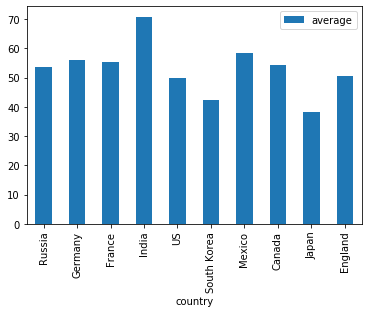

In [11]:
titlelen = nodup_data.withColumn('titleLength', length('title'))
average_by_group(titlelen, 'country', 'titleLength').toPandas().plot(kind='bar', y='average', x='country')

In [ ]:
desclen = nodup_data.withColumn('descriptionLength', length('description'))
average_by_group(desclen, 'country', 'descriptionLength').toPandas().plot(kind='bar', y='average', x='country')

## possible word cloud
pip install wordcloud

In [14]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

In [15]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
##takes a long ass time for descriptions ***********~40 mins*************
# iterate through the column
def wordCloud(df, column):
    comment_words = ''
    for val in df[column]: 
      
        # typecaste each val to string 
        val = str(val) 
  
        # split the value 
        tokens = val.split() 
      
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
      
        comment_words += " ".join(tokens)+" "
  
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words)

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

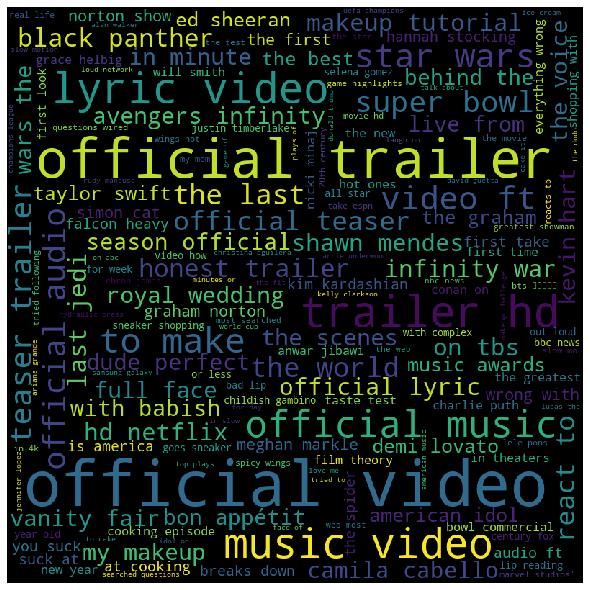

In [16]:
test = us_data.toPandas()
test = test[test['title'].notna()]
test = test[test['description'].notna()]
wordCloud(test, 'title')

In [ ]:
#this is gunna take a very long time!!!!!!!!!!!!!!!!!!!!!!1
#wordCloud(test, 'description')

## Keyword frequency count (us data)

In [126]:
def keyWords(df, column, amount):
    temp = Counter(" ".join(df[column].str.lower()).split()).most_common(amount)
    pd.DataFrame(temp, columns=['word', 'count']).plot(kind='bar', x='word', y='count')

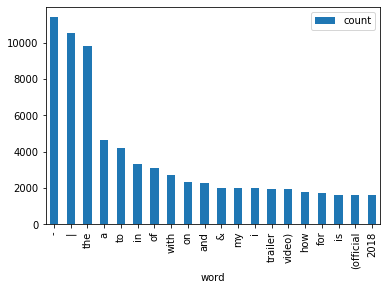

In [127]:
keyWords(test, "title", 20)

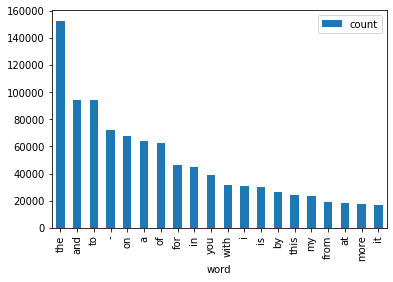

In [128]:
keyWords(test, "description", 20)

In [138]:
def keyWords_filtered(df, column, amount):
    pattern = '|'.join(['\|', ';', '-', '\(', '\)', '\[', '\]', '&', ' ', '\.', '\,', '\:', '\/', '\'', '\!', '\$', '’', '\\\\'])
    some[column] = df[column].str.lower().str.replace(pattern, ' ').str.replace(r'\b(\w{1,3})\b', '')
    temp = Counter(" ".join(some[column]).split()).most_common(20)
    pd.DataFrame(temp, columns=['word', 'count']).plot(kind='bar', x='word', y='count')

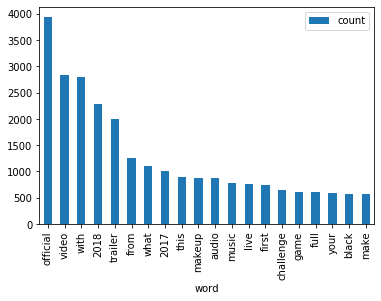

In [139]:
keyWords_filtered(test, "title", 20)

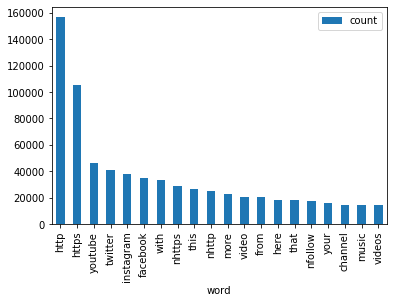

In [140]:
keyWords_filtered(test, "description", 20)